In [1]:
from glob import glob
from tqdm import tqdm
import pandas as pd
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # Hide TF deprecation messages
import matplotlib.pyplot as plt
import trimesh
import random
import numpy as np
import pickle
import modules
import data_utils

2023-07-15 21:03:43.478136: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import datetime
from tensorflow import summary as s
log_dir = "logs/text/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = s.FileWriter(log_dir)

In [3]:
chair_meshes_paths = list(glob("chairs_ngon/*.obj"))
chair_meshes_paths = [["Chair", path] for path in chair_meshes_paths]
tables_meshes_paths = list(glob("tables_ngon/*.obj"))
tables_meshes_paths = [["Table", path] for path in tables_meshes_paths]
chair_meshes_paths.extend(tables_meshes_paths)
paths = chair_meshes_paths.copy()
random.shuffle(paths)

In [4]:
captions = pd.read_csv("captions_tablechair.csv").dropna()

In [5]:
captions

id                           modelId  \
0      118462  e702f89ce87a0b6579368d1198f406e7   
1      118461  b654fef8eb98e99d65ba78ad9601cf1b   
2      118460  df5b55da209637624b3c42e318f3affc   
3      118459  791c14d53bd565f56ba14bfd91a75020   
4      118458  6730f663d0e012506f525e79a05bbcb3   
...       ...                               ...   
75355   23226  10fbf670bb017ec94ebb593f0d0b4581   
75356   23213  bae518da1e709e83596f70d1d7edd4bc   
75357   23185  bae518da1e709e83596f70d1d7edd4bc   
75358   23159   1ef6c2b9d413fb7c681404257d94ad9   
75359   23142  171a3677999c79b32c8109e73b98d509   

                                             description category  \
0      the table is round and has 3 legs. the table i...    Table   
1      the chair is made of plastic and has 4 legs, i...    Chair   
2      It is narrow console table.It is made from ply...    Table   
3      A simple chair with wooden back rest and seati...    Chair   
4      It is simple chiar with comfortable back rest ...    Chair   
...                                                  ...      ...   
75355                   A tall table used for decoration    Table   
75356  Confortable and adjustable chair probably made...    Chair   
75357  The chair is unique and adjustable.  There is ...    Chair   
75358  Wooden table with four legs and a centerpiece ...    Table   
75359           Nice long table to fit the whole family.    Table   

       topLevelSynsetId  subSynsetId  
0               4379243      4379243  
1               3001627      4331277  
2               4379243      3092883  
3               3001627     20000020  
4               3001627     20000020  
...                 ...          ...  
75355           4379243      3092883  
75356           3001627      4373704  
75357           3001627      4373704  
75358           4379243      4379243  
75359           4379243      4379243  

[75358 rows x 6 columns]

In [6]:
max_length = 0
for c in captions['description'].values:
    cur = len(c.split(" "))
    if cur>max_length:
        max_length =cur
max_length


140

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(captions['description'].values)

In [8]:
def text2shape(paths, captions, tokenizer):
    for cls, path in paths:
        # with open(path, 'rb') as obj_file:
        mesh_dict = data_utils.load_process_mesh(path)
        mesh_dict['class_label'] = 18 if cls=="Chair" else 49
        if len(mesh_dict['faces'])>2600:
            continue
        try:
            text = captions[captions["modelId"]==path.split("/")[-1].replace(".obj", "")].sample(n=1)["description"].values[0]
        except:
            continue
        text = text.lower().replace("the", '').replace("a", '').replace("of", '').replace("for", '').replace("and", '').replace("to", '').replace("in", '')
        text = tokenizer.texts_to_sequences([text])[0]
        mesh_dict['text_feature'] = np.pad(text, (0,max_length-len(text)))
        yield mesh_dict
        break

In [9]:
Text2ShapeDataset = tf.data.Dataset.from_generator(
        lambda:text2shape(paths, captions, tk),
        output_types={
            'vertices': tf.int32, 'faces': tf.int32,
            'class_label': tf.int32,
            'text_feature': tf.int32},
        output_shapes={
            'vertices': tf.TensorShape([None, 3]), 'faces': tf.TensorShape([None]),
            'class_label': tf.TensorShape(()),
            'text_feature':tf.TensorShape(140)})
ex = Text2ShapeDataset.make_one_shot_iterator().get_next()

In [10]:
ex

{'vertices': <tf.Tensor 'IteratorGetNext:3' shape=(?, 3) dtype=int32>,
 'faces': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>,
 'class_label': <tf.Tensor 'IteratorGetNext:0' shape=() dtype=int32>,
 'text_feature': <tf.Tensor 'IteratorGetNext:2' shape=(140,) dtype=int32>}

In [11]:
# with tf.Session() as sess:
#     ex_np = sess.run(ex)
# print(ex_np)

# # Plot the meshes
# mesh_list = []
# with tf.Session() as sess:
#     for i in range(8):
#         ex_np = sess.run(ex)
#         mesh_list.append(
#         {'vertices': data_utils.dequantize_verts(ex_np['vertices']),
#          'faces': data_utils.unflatten_faces(ex_np['faces'])})
# data_utils.plot_meshes(mesh_list, ax_lims=0.4)

In [12]:
vertex_model_dataset = data_utils.make_vertex_model_dataset(
    Text2ShapeDataset, apply_random_shift=False)
vertex_model_dataset = vertex_model_dataset.repeat()
vertex_model_dataset = vertex_model_dataset.padded_batch(
    4, padded_shapes=vertex_model_dataset.output_shapes)
vertex_model_dataset = vertex_model_dataset.prefetch(1)
vertex_model_batch = vertex_model_dataset.make_one_shot_iterator().get_next()

In [13]:
vertex_model = modules.TextToVertexModel(
    decoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=24,
      dropout_rate=0.4,
      re_zero=True,
      memory_efficient=True
      ),
    path_to_embeddings="glove.6B/glove.6B.100d.txt",
    quantization_bits=8,
    tokenizer=tk,
    max_num_input_verts=5000,  # number of vertices in the input mesh, if this is lower than the number of vertices in the mesh, there will be errors during training
    use_discrete_embeddings=True
)

Found 400000 word vectors.
Converted 8371 words (2938 misses)


In [14]:
vertex_model_pred_dist = vertex_model(vertex_model_batch)
vertex_model_loss = -tf.reduce_sum(
    vertex_model_pred_dist.log_prob(vertex_model_batch['vertices_flat']) *
    vertex_model_batch['vertices_flat_mask'])
vertex_samples = vertex_model.sample(
    4, context=vertex_model_batch, max_sample_length=1000, top_p=0.95,
    recenter_verts=False, only_return_complete=False)

print(vertex_model_batch)
print(vertex_model_pred_dist)


{'vertices': <tf.Tensor 'IteratorGetNext_1:3' shape=(?, ?, 3) dtype=int32>, 'faces': <tf.Tensor 'IteratorGetNext_1:1' shape=(?, ?) dtype=int32>, 'class_label': <tf.Tensor 'IteratorGetNext_1:0' shape=(?,) dtype=int32>, 'text_feature': <tf.Tensor 'IteratorGetNext_1:2' shape=(?, 140) dtype=int32>, 'vertices_flat': <tf.Tensor 'IteratorGetNext_1:4' shape=(?, ?) dtype=int32>, 'vertices_flat_mask': <tf.Tensor 'IteratorGetNext_1:5' shape=(?, ?) dtype=float32>}
tfp.distributions.Categorical("vertex_model_2/vertex_model/create_dist/Categorical/", batch_shape=[?, ?], event_shape=[], dtype=int32)


In [15]:
# vertex_module_config=dict(
#   decoder_config=dict(
#       hidden_size=512,
#       fc_size=2048,
#       num_heads=8,
#       layer_norm=True,
#       num_layers=24,
#       dropout_rate=0.4,
#       re_zero=True,
#       memory_efficient=True
#       ),
#   quantization_bits=8,
#   class_conditional=True,
#   max_num_input_verts=5000,
#   use_discrete_embeddings=True,
#   )
# vertex_model1 = modules.VertexModel(**vertex_module_config)

In [16]:
# vertex_model_pred_dist = vertex_model(vertex_model_batch)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     text_vars = vertex_model.variables
# print(text_vars)


In [17]:
# vertex_model1_pred_dist = vertex_model1(vertex_model_batch)
# with tf.Session() as sess:
#     orig_vars = vertex_model1.variables
# print(orig_vars)


In [18]:
# text_vars_names = []
# for v in text_vars:
# #     shape = tuple()
# #     for dim in v._variable._shape_val._dims:
# #         shape = shape+(dim._value,)
# #     text_vars_names.append(('/'.join((v._variable._name).split('/')[1:]), shape))
#     text_vars_names.append('/'.join((v._variable._name).split('/')[1:]))
# print(text_vars_names)

#'coord_embeddings/embeddings:0', 'coord_embeddings_1/embeddings:0', 'embed/embeddings:0', 'embed_zero:0', 'linear/b:0', 'linear/w:0', 'linear_1/b:0', 'linear_1/w:0'


In [19]:
# orig_vars_names = []
# for v in orig_vars:
# #     shape = tuple()
# #     for dim in v._variable._shape_val._dims:
# #         shape = shape+(dim._value,)
# #     orig_vars_names.append(('/'.join((v._variable._name).split('/')[1:]), shape))
#     orig_vars_names.append('/'.join((v._variable._name).split('/')[1:]))
# print(orig_vars_names)


In [20]:
# common_vars = set(text_vars_names) & set(orig_vars_names)
# print(common_vars)
# only_text_vars = set(text_vars_names) - common_vars
# print(only_text_vars)

In [21]:
# only_text_vars = set(text_vars_names) - common_vars
# print(only_text_vars)

In [22]:
# set(orig_vars_names) - common_vars

In [23]:
# import pickle
# with open("only_text_vars.pickle", 'wb') as out:
#     pickle.dump(only_text_vars, out)

In [24]:
with open("only_text_vars.pickle", 'rb') as f:
    only_text_vars = pickle.load(f)

text_vars = []
for var in vertex_model.variables:
    if '/'.join((var._variable._name).split('/')[1:]) in only_text_vars:
        text_vars.append(var)
text_vars=tuple(text_vars)
print(text_vars)

(<tf.Variable 'vertex_model/embed/embeddings:0' shape=(11311, 100) dtype=float32_ref>, <tf.Variable 'vertex_model/embed_zero:0' shape=(1, 1, 512) dtype=float32_ref>, <tf.Variable 'vertex_model/linear/b:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'vertex_model/linear/w:0' shape=(14000, 512) dtype=float32_ref>, <tf.Variable 'vertex_model/linear_1/b:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'vertex_model/linear_1/w:0' shape=(512, 512) dtype=float32_ref>, <tf.Variable 'vertex_model/transformer_decoder/layer_0/cross_attention/alpha:0' shape=() dtype=float32_ref>, <tf.Variable 'vertex_model/transformer_decoder/layer_0/cross_attention/k/kernel:0' shape=(512, 512) dtype=float32_ref>, <tf.Variable 'vertex_model/transformer_decoder/layer_0/cross_attention/layer_norm_bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'vertex_model/transformer_decoder/layer_0/cross_attention/layer_norm_scale:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'vertex_model/transformer_decoder/layer_0/c

In [25]:
import pickle
with open("pretrained_vars.pickle", 'rb') as f:
    common_vars = pickle.load(f)

pretrained_vars = []
for var in vertex_model.variables:
    if '/'.join((var._variable._name).split('/')[1:]) in common_vars:
        pretrained_vars.append(var)
pretrained_vars=tuple(pretrained_vars)
# print(pretrained_vars)

In [26]:
vertex_model_saver = tf.train.Saver(var_list=pretrained_vars)

In [27]:
# with tf.Session() as sess:
#   vertex_model_saver.restore(sess, "D:\\PyCharmProjects\\vertex_model\\model")

In [28]:
face_model_dataset = data_utils.make_face_model_dataset(
    Text2ShapeDataset, apply_random_shift=False)
face_model_dataset = face_model_dataset.repeat()
face_model_dataset = face_model_dataset.padded_batch(
    4, padded_shapes=face_model_dataset.output_shapes)
face_model_dataset = face_model_dataset.prefetch(1)
face_model_batch = face_model_dataset.make_one_shot_iterator().get_next()

# Create face model
face_model = modules.FaceModel(
      encoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=10,
      dropout_rate=0.2,
      re_zero=True,
      memory_efficient=True,
      ),
  decoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=14,
      dropout_rate=0.2,
      re_zero=True,
      memory_efficient=True,
      ),
    class_conditional=False,
    max_seq_length=8000, # number of faces in the input mesh, if this is lower than the number of vertices in the mesh, there will be errors during training
    quantization_bits=8,
    decoder_cross_attention=True,
    use_discrete_vertex_embeddings=True,
)
face_model_pred_dist = face_model(face_model_batch)
face_model_loss = -tf.reduce_sum(
    face_model_pred_dist.log_prob(face_model_batch['faces']) *
    face_model_batch['faces_mask'])
face_samples = face_model.sample(
    context=vertex_samples, max_sample_length=1000, top_p=0.95,
    only_return_complete=False)
print(face_model_batch)
print(face_model_pred_dist)
print(face_samples)

{'vertices': <tf.Tensor 'IteratorGetNext_2:5' shape=(?, ?, 3) dtype=float32>, 'faces': <tf.Tensor 'IteratorGetNext_2:1' shape=(?, ?) dtype=int64>, 'class_label': <tf.Tensor 'IteratorGetNext_2:0' shape=(?,) dtype=int32>, 'text_feature': <tf.Tensor 'IteratorGetNext_2:4' shape=(?, 140) dtype=int32>, 'num_vertices': <tf.Tensor 'IteratorGetNext_2:3' shape=(?,) dtype=int32>, 'vertices_mask': <tf.Tensor 'IteratorGetNext_2:6' shape=(?, ?) dtype=float32>, 'faces_mask': <tf.Tensor 'IteratorGetNext_2:2' shape=(?, ?) dtype=float32>}
tfp.distributions.Categorical("face_model_1/face_model/create_dist/Categorical/", batch_shape=[?, ?], event_shape=[], dtype=int32)
{'context': {'completed': <tf.Tensor 'Any:0' shape=(?,) dtype=bool>, 'vertices': <tf.Tensor 'mul_4:0' shape=(?, 1000, 3) dtype=float32>, 'num_vertices': <tf.Tensor 'floordiv:0' shape=(?,) dtype=int32>, 'vertices_mask': <tf.Tensor 'Cast_2:0' shape=(?, 1000) dtype=float32>}, 'completed': <tf.Tensor 'Any_1:0' shape=(?,) dtype=bool>, 'faces': <

In [29]:
face_model_saver = tf.train.Saver(var_list=face_model.variables)

In [30]:
# c = tf.ConfigProto()
# c.gpu_options.allow_growth = True

In [ ]:
text_model_saver = tf.train.Saver(var_list=vertex_model.variables, keep_checkpoint_every_n_hours=1, max_to_keep=10)

2023-07-15 21:07:13.145509: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-15 21:07:13.230923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1669] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.74
pciBusID: 0000:65:00.0
2023-07-15 21:07:13.230980: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-07-15 21:07:13.260731: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-07-15 21:07:13.264406: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2023-07-15 21:07:13.265322: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2023-07-15 21:07:13.266119: I tensorflow/stream_executor/platform/

Step 0
Loss (vertices) 1784.4361572265625


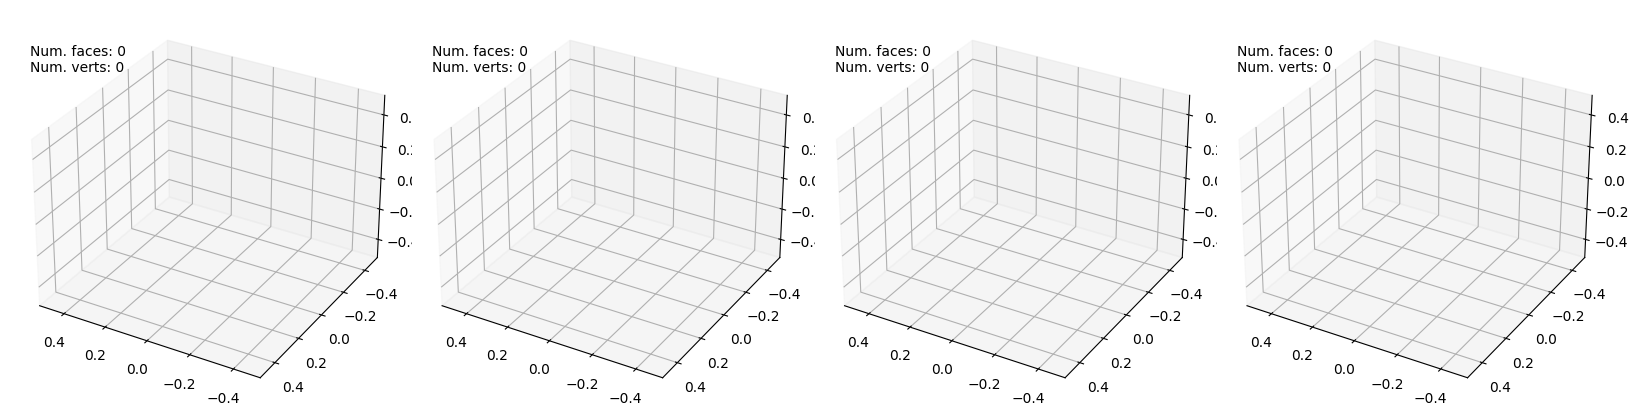

Step 10
Loss (vertices) 429.5701904296875


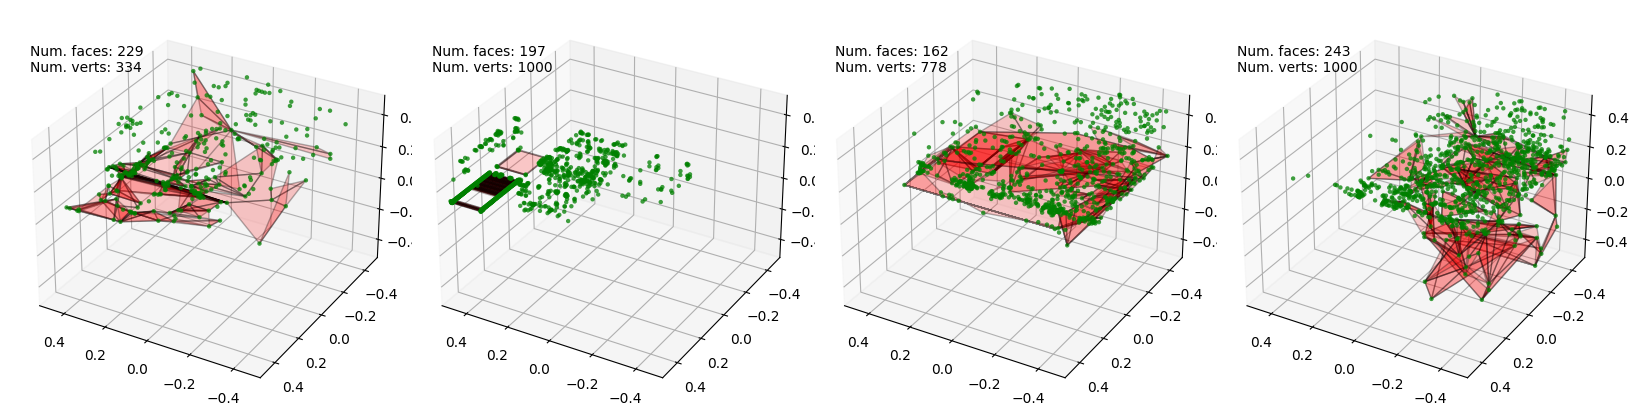

Step 20
Loss (vertices) 158.905517578125


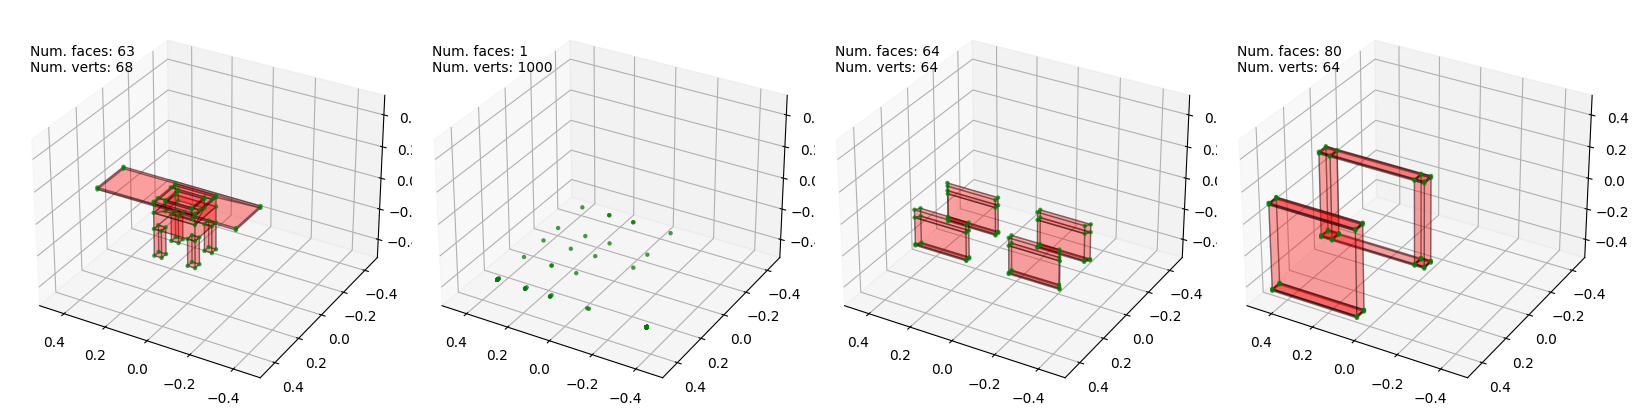

Step 30
Loss (vertices) 46.340885162353516


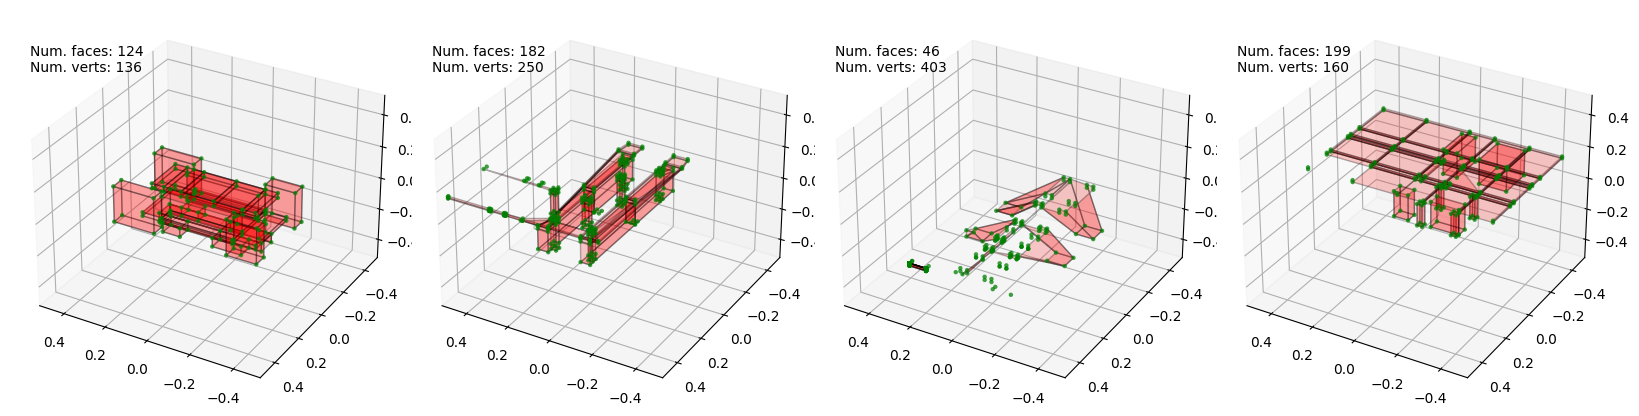

Step 40
Loss (vertices) 15.474444389343262


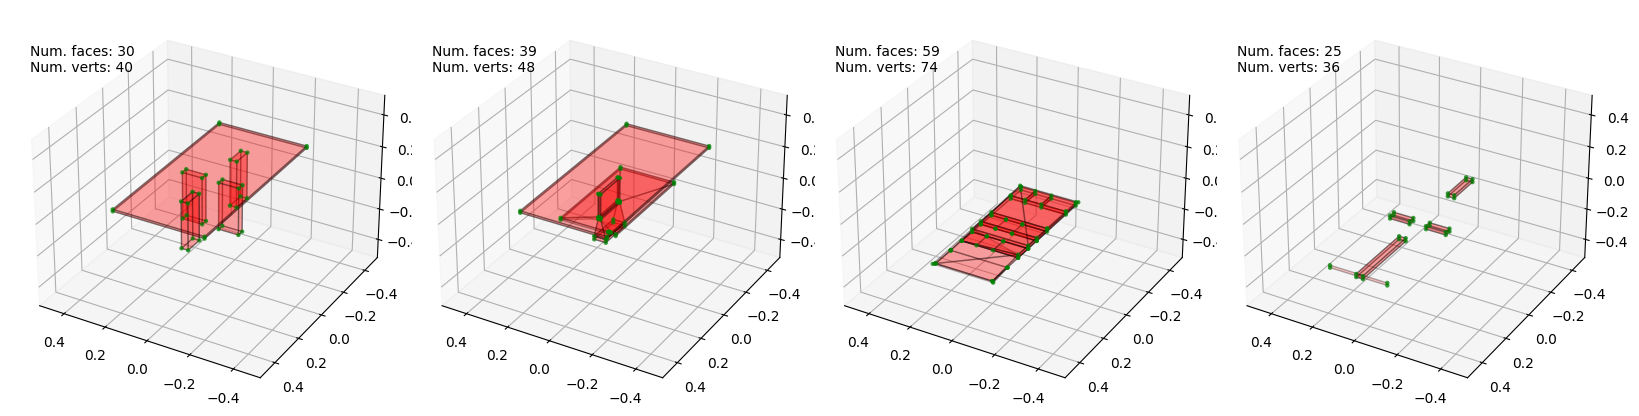

Step 50
Loss (vertices) 5.444444179534912


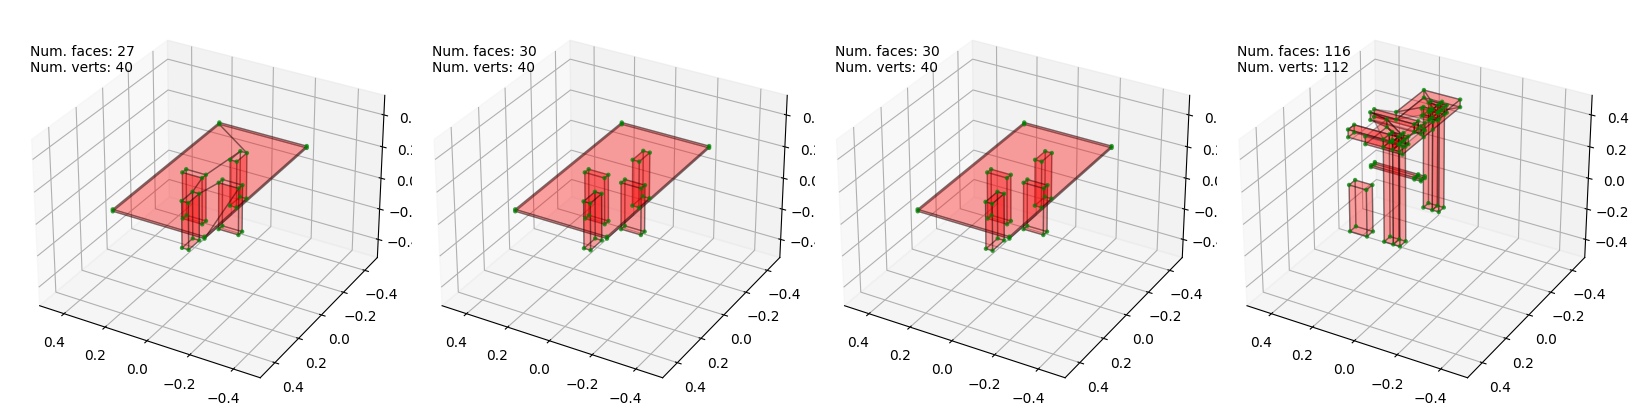

Step 60
Loss (vertices) 3.082608222961426


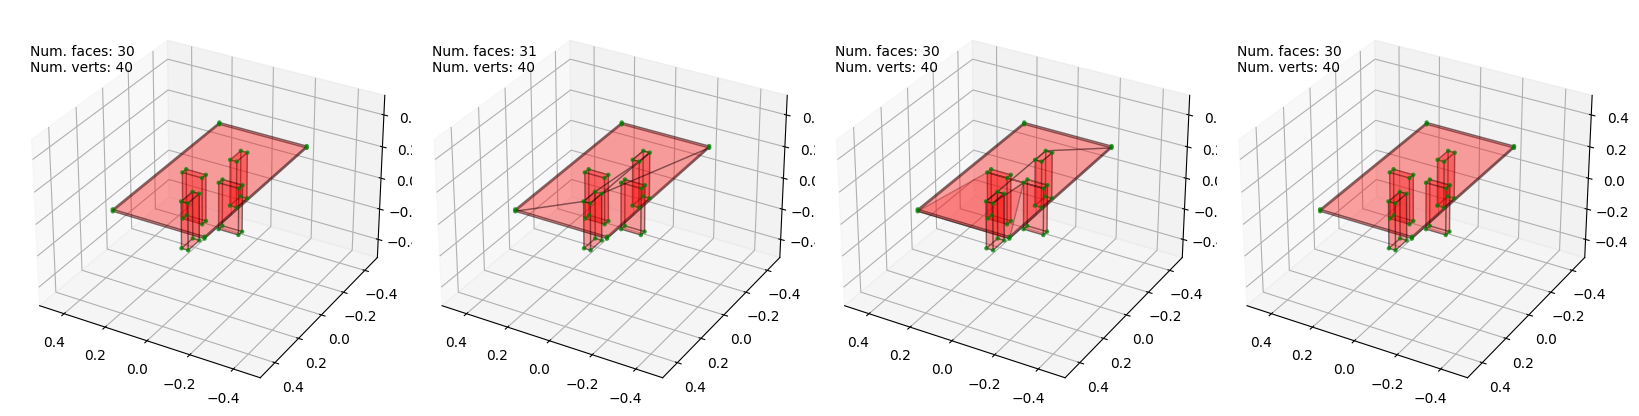

Step 70
Loss (vertices) 1.8437923192977905


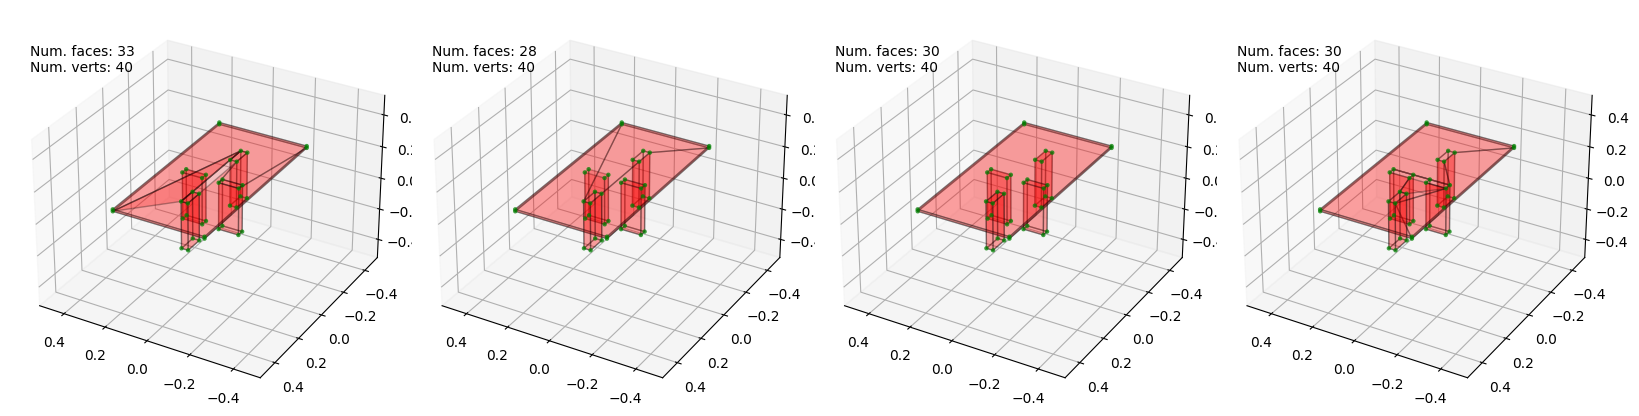

Step 80
Loss (vertices) 1.2683863639831543


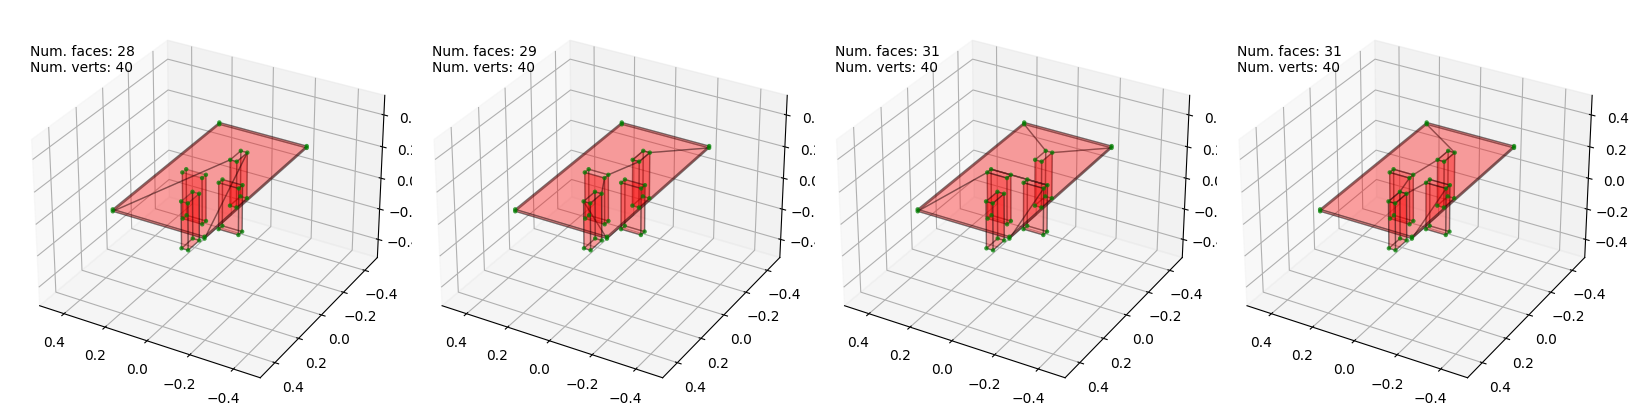

Step 90
Loss (vertices) 0.9501747488975525


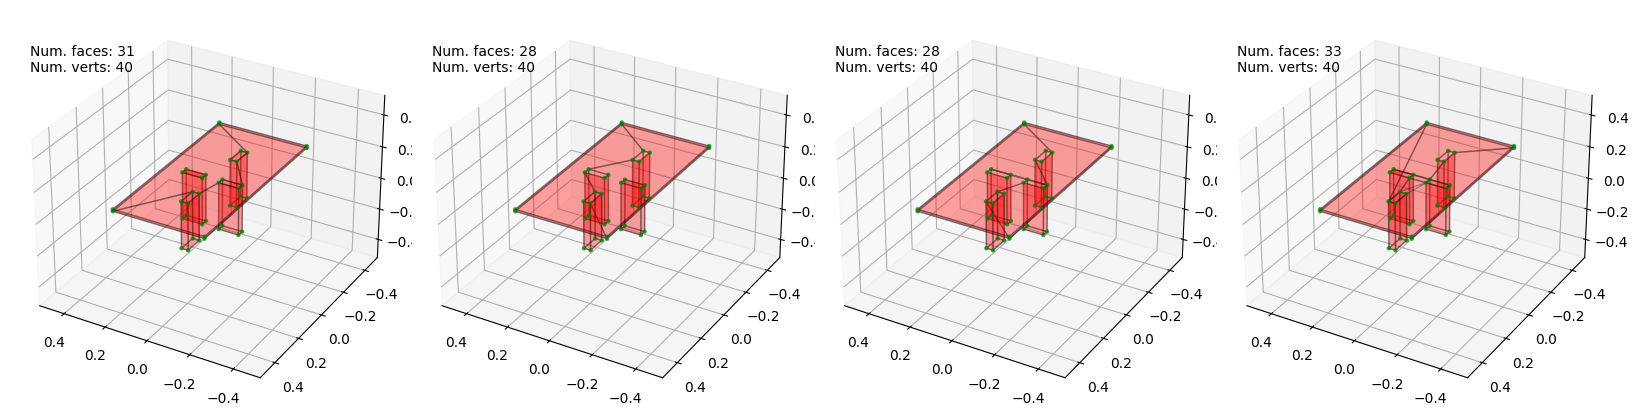

Step 100
Loss (vertices) 0.7568808794021606


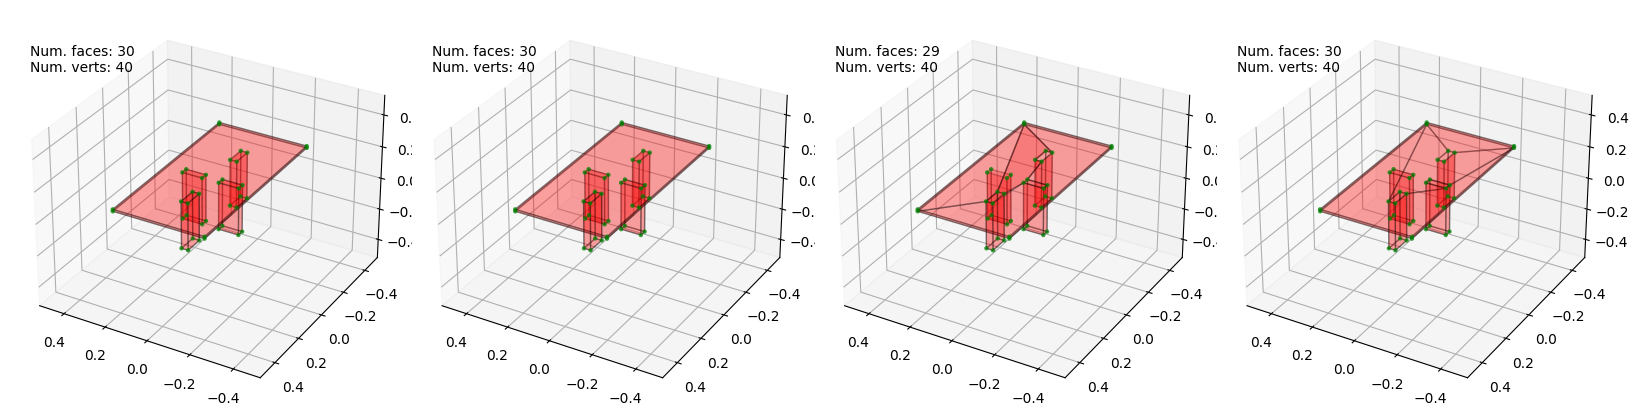

Step 110
Loss (vertices) 0.6218196749687195


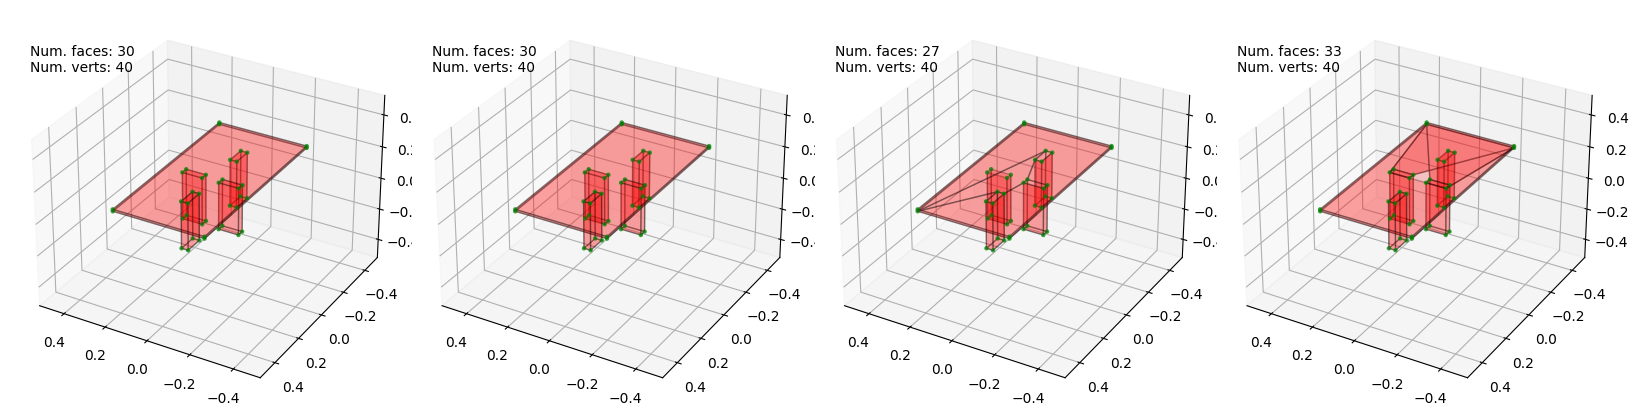

Step 120
Loss (vertices) 0.5404565930366516


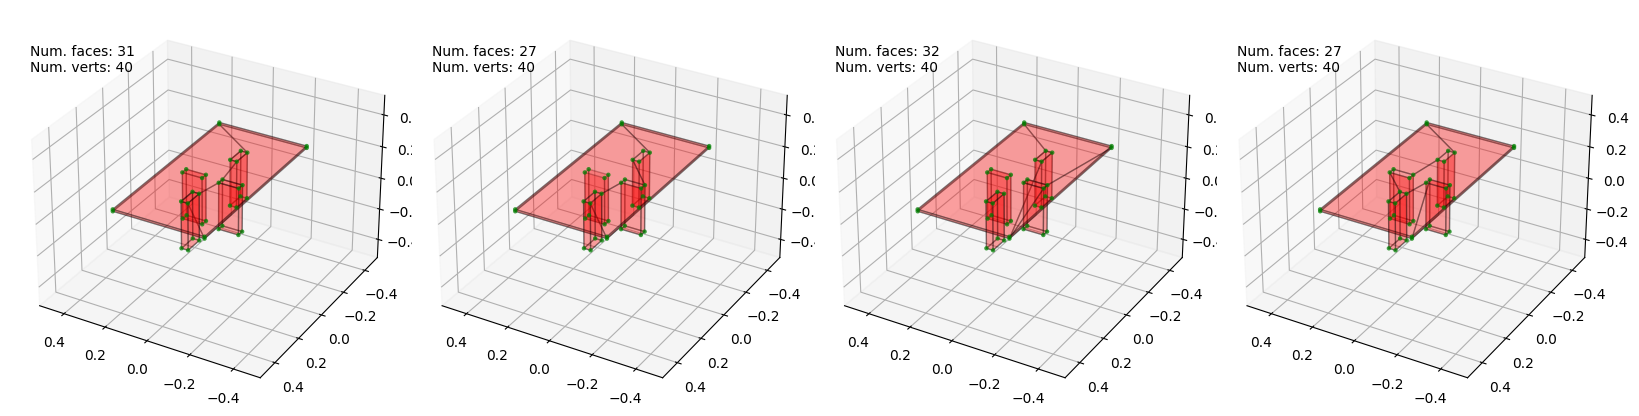

Step 130
Loss (vertices) 0.45105859637260437


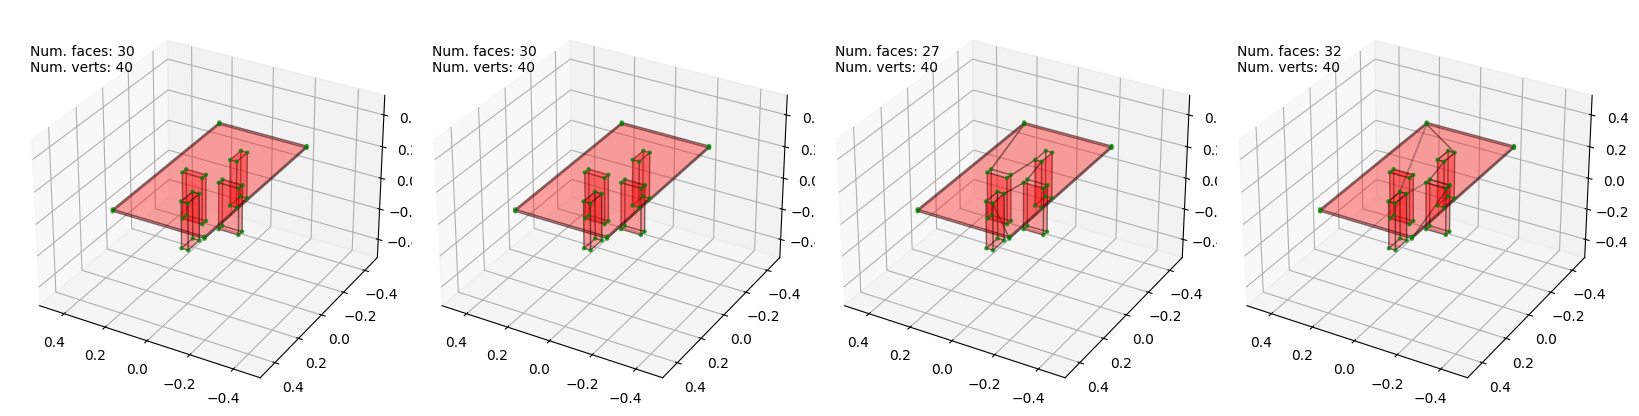

Step 140
Loss (vertices) 0.4007568955421448


In [ ]:
from tqdm import tqdm
%matplotlib inline 
learning_rate = 5e-4
training_steps = 500
check_step = 10

# Create an optimizer an minimize the summed log probability of the mesh
# sequences
optimizer = tf.train.AdamOptimizer(learning_rate)
vertex_model_optim_op = optimizer.minimize(vertex_model_loss, var_list=text_vars)
# face_model_optim_op = optimizer.minimize(face_model_loss, var_list=text_vars)
best_v_loss = float('inf')
# Training loop
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    vertex_model_saver.restore(sess, "vertex_model/model")
    face_model_saver.restore(sess, 'face_model/model')
    for n in range(training_steps):
        if n % check_step == 0:
#             v_loss, f_loss = sess.run((vertex_model_loss, face_model_loss))
            v_loss = sess.run(vertex_model_loss)
            with summary_writer:
                tf.summary.scalar('vertex_loss', v_loss)
#                 tf.summary.scalar('face_loss', f_loss)
            if v_loss<best_v_loss:
                text_model_saver.save(sess, 'text_model', global_step=n)
            print('Step {}'.format(n))
            print('Loss (vertices) {}'.format(v_loss))
#             print('Loss (faces) {}'.format(f_loss))

            v_samples_np, f_samples_np, b_np = sess.run((vertex_samples, face_samples, vertex_model_batch))
            mesh_list = []
            for n in tqdm(range(4)):
                mesh_list.append({
                'vertices': v_samples_np['vertices'][n][:v_samples_np['num_vertices'][n]],
                'faces': data_utils.unflatten_faces(
                    f_samples_np['faces'][n][:f_samples_np['num_face_indices'][n]])
                })
            data_utils.plot_meshes(mesh_list, ax_lims=0.5)
#         sess.run((vertex_model_optim_op, face_model_optim_op))
        sess.run(vertex_model_optim_op)